In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import freud
from scipy.stats import uniform
from scipy.optimize import curve_fit
from scipy.special import erf



In [4]:
# Extracting Positions and Box from Files

files = ['1.pdb', '2.pdb']
atom_number = 4350
pos = []
typ = []
box = []

for file in files:
    print(file)
    with open('to_a_water_slab/{}'.format(file)) as f:
        lines = f.readlines()
        box.append(np.fromstring(lines[1][8:32], sep=' '))


        for line in lines:
            if line[:6] == "HETATM":
                a = 1
                #print(line[30:-5])
                typ.append(line[13:16].strip())
                pos.append(np.fromstring(line[30:-5], sep=' '))
                #break
                
pos = np.array(pos)
typ = np.array(typ, dtype='object')
lenpos = int(len(pos) / atom_number)


water_air_pos = np.reshape(pos, [lenpos, atom_number, 5])[:,:,:3]
water_air_typ = np.reshape(typ, [lenpos, atom_number])
water_air_box = box[0]
        
print(water_air_box)

1.pdb
2.pdb
[ 36.  36. 700.]


1073
H1


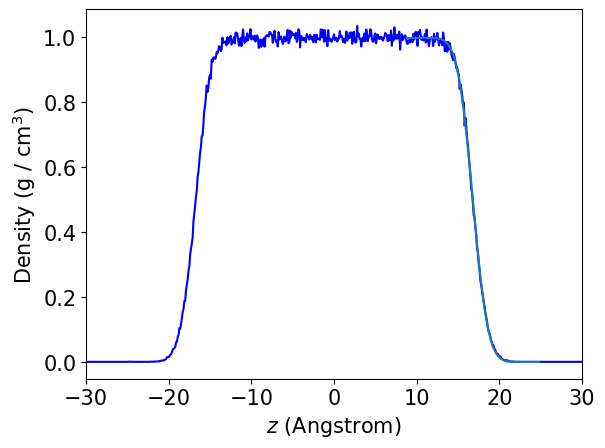

In [5]:
# Separating into H and O, finding GDS

subtract = [-10]
Hposes = []
Oposes = []


water_function = lambda x, xo, scale, height: height*(erf(scale*(x - xo))/2 + 0.5)


for it in range(len(water_air_pos)):
    pos = water_air_pos[it]
    typ = water_air_typ[it]
    box = np.copy(water_air_box)

    fbox = freud.box.Box.from_box(box) #freud.box allows for easy wrapping of particle positions

    whO = np.where(typ == 'OH2')[0]
    whH = np.where((typ == 'H1') + (typ == 'H2'))[0]
    
    
    Opos = fbox.wrap(pos[whO])# + [25, 0, 0])
    Hpos = fbox.wrap(pos[whH])# + [25, 0, 0])
    


    Hpos = fbox.wrap(Hpos - [0, 0, np.average(Opos[:,2])]) #Centering Positions
    Opos = fbox.wrap(Opos - [0, 0, np.average(Opos[:,2])])




    Oposes.append(Opos)
    Hposes.append(Hpos)
    #break
        
boxW = box[0]**2 #Box area
start = 100 #Earliest Frame to include in data
tot = np.concatenate(Oposes[start:])
un, co = np.unique(np.round(tot[:,2], 1), return_counts=True)
dens = co/(len(water_air_pos) - start)/boxW/0.1/(1/18.02 * 6.022 * 10**23 / 10**24)
plt.plot(un, dens, c='Blue') # Density Distribution
plt.xlim(-30, 30)
       

print(len(Oposes))
rwater_var, rwater_cov = curve_fit(water_function, 
                                   un[un > 0], 
                                   dens[un > 0], 
                                   [18, 1, 1],
                                   maxfev = int (2e5))

xx = np.linspace(rwater_var[0] - 8, rwater_var[0]+8)
yy = water_function(xx, *rwater_var)
plt.plot(xx, yy)

plt.ylabel('Density (g / cm$^3$)', fontsize=15)
plt.xlabel('$z$ (Angstrom)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

airgds = rwater_var[0] # GDS

airOpos = np.copy(Oposes)
airHpos = np.copy(Hposes) 

print(typ[1])

In [53]:
gridlenx = 36*2
dx = 1/gridlenx
xs = np.linspace(dx/2, 1 - dx/2, gridlenx)
ys = np.copy(xs)

gridlenz = 16*2
dz = 1/gridlenz
zs = np.linspace(dz/2, 1 - dz/2, gridlenz)

grid = []
for x in xs:
    for y in ys:
        for z in zs:
            grid.append([x, y, z])
            
grid = np.array(grid)
print(len(grid))
print(grid)

from skimage import measure


#print(gds)




165888
[[0.00694444 0.00694444 0.015625  ]
 [0.00694444 0.00694444 0.046875  ]
 [0.00694444 0.00694444 0.078125  ]
 ...
 [0.99305556 0.99305556 0.921875  ]
 [0.99305556 0.99305556 0.953125  ]
 [0.99305556 0.99305556 0.984375  ]]


In [54]:
gds = rwater_var[0]
extantz = 16
chi = 2.4
gridxy = 10000*grid[:,0] + grid[:,0]
rmax = chi*3.0
boundaries = []
bdis = []
gdis = []
Hbdis = []
Hgdis = []

for k in range(500, len(airOpos), 1):
    
    Oposes = np.copy(airOpos[k])
    Hposes = np.copy(airHpos[k])
    box = np.copy(water_air_box)
    
    # Setting up grigd
    mgrid = np.copy(grid)
    mgrid[:,:2] = mgrid[:,:2]*box[:2] - box[:2]/2
    
    mgrid[:,2] = mgrid[:,2] * extantz - extantz/2 + gds
    
    
    # Computing Density on Grid
    tOpos = Oposes[Oposes[:,2] > 0]
    fbox = freud.box.Box.from_box(box)
    aq = freud.locality.AABBQuery(fbox, tOpos)
    nlist = aq.query(mgrid, {'r_max': rmax}).toNeighborList()   
    dgs = np.array([dx*box[0], dx*box[1], dz*extantz])
    dis = np.linalg.norm(fbox.wrap(tOpos[nlist.point_indices] - mgrid[nlist.query_point_indices]), axis=1)
    gauss = 1/(2*np.pi*chi**2)**(3/2)*np.exp(-0.5*(dis/chi)**2)
    gauss = gauss - 1/(2*np.pi*chi**2)**(3/2)*np.exp(-0.5*(rmax/chi)**2)
    
    un, co = np.unique(nlist.query_point_indices, return_counts=True)
    dens = []
    it = 0
    total = np.arange(0, len(mgrid))
    dens = np.zeros(len(grid))
    i = 0
    for u in un:
        et = it + co[i]
        wh = np.arange(it, et)
        dens[u] = np.sum(gauss[wh])
        it = et
        i += 1

    tgrid = np.reshape(dens, [gridlenx, gridlenx, gridlenz])

    # Finding Interface   
    dens = np.array(dens)
    verts, faces, normals, values = measure.marching_cubes(tgrid, 0.016, spacing=(dgs[0], dgs[1], dgs[2]))
    verts[:,2] =  verts[:,2] - extantz/2 + gds + dgs[2]/2
    verts[:,:2] =  verts[:,:2] - box[:2]/2 + dgs[:2]/2

    # Finding how close particles are to Interface
    nneighbors = 1
    tOpos = np.copy(Oposes[Oposes[:,2] > 0])
    gbox = box * np.array([1, 1, 4])
    fbox = freud.box.Box.from_box(gbox)

    aq = freud.locality.AABBQuery(fbox, verts)
    nlist = aq.query(tOpos, {'num_neighbors': nneighbors}).toNeighborList()   
    #print('here1')
    directs = fbox.wrap(verts[nlist.point_indices] - tOpos[nlist.query_point_indices])
    dis = np.linalg.norm(directs, axis=1)
    normed = (directs.T / dis).T
    signs = np.sign(normed[:,2])

    dis = np.sum(directs*normed, axis=1) * signs
    bdis.append(dis)
    gdis.append(tOpos[:,2])
    
    
    tHpos = np.copy(Hposes[Hposes[:,2] > 0])
    gbox = box * np.array([1, 1, 4])
    fbox = freud.box.Box.from_box(gbox)

    aq = freud.locality.AABBQuery(fbox, verts)
    nlist = aq.query(tHpos, {'num_neighbors': nneighbors}).toNeighborList()   
    directs = fbox.wrap(verts[nlist.point_indices] - tHpos[nlist.query_point_indices])
    dis = np.linalg.norm(directs, axis=1)
    normed = (directs.T / dis).T
    signs = np.sign(normed[:,2])

    dis = np.sum(directs*normed, axis=1) * signs
    Hbdis.append(dis)
    Hgdis.append(tHpos[:,2])
    
    
    print(k)
    
airdis = np.array(bdis, dtype='object')


airHdis = np.array(Hbdis, dtype='object')


#print(airdis)


500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749


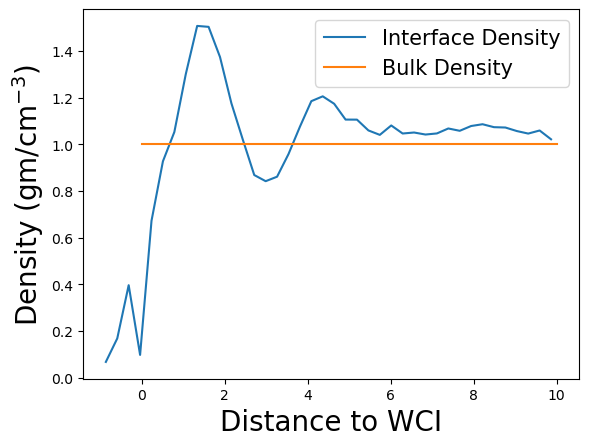

In [72]:
boxW = 36**2 #Area



coco, bins = np.histogram(np.concatenate(airdis), range = (-1, 10.0), bins = 40)
binw = bins[1] - bins[0]
unco = bins[:-1] + binw/2
plt.plot(unco, 
         coco/boxW/binw/len(airdis)/(1/18.02 * 6.022 * 10**23 / 10**24),
         label='Interface Density') # Density Using Oxygens



plt.plot([0, 10], [1, 1], label='Bulk Density')
plt.xlabel("Distance to WCI", size=20)
plt.ylabel("Density (gm/cm$^{-3}$)", size=20)

plt.legend(fontsize=15)

airnum = np.copy(unco)
airden = np.copy(coco)

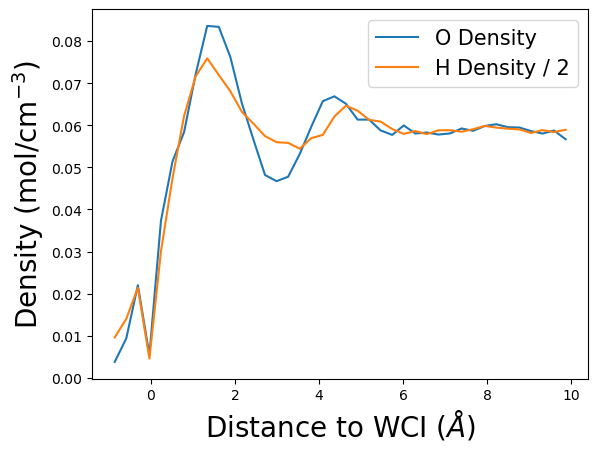

In [73]:
boxW = 36**2 #Area



coco, bins = np.histogram(np.concatenate(airdis), range = (-1, 10.0), bins = 40)
binw = bins[1] - bins[0]
unco = bins[:-1] + binw/2
plt.plot(unco, coco/boxW/binw/len(airdis)/(1 * 6.022 * 10**23 / 10**24), label='O Density') # O positions


coco, bins = np.histogram(np.concatenate(airHdis), range = (-1, 10.0), bins = 40)
binw = bins[1] - bins[0]
unco = bins[:-1] + binw/2
plt.plot(unco, coco/boxW/binw/len(airdis)/(1 * 6.022 * 10**23 / 10**24)/2, label='H Density / 2') # H positions



plt.xlabel("Distance to WCI ($\AA$)", size=20)
plt.ylabel("Density (mol/cm$^{-3}$)", size=20)

plt.legend(fontsize=15)




In [64]:
files = ['1.pdb', '2.pdb', '3.pdb', '4.pdb']
atom_number = 8350
pos = []
typ = []
box = []
for file in files:
    print(file)
    with open('to_a_water-hexane/{}'.format(file)) as f:
        lines = f.readlines()
        box.append(np.fromstring(lines[1][8:32], sep=' '))

        #if 1 == 1:
        #    continue
        for line in lines:
            if line[:6] == "HETATM":
                a = 1
                #print(line[30:-5])
                typ.append(line[13:16].strip())
                pos.append(np.fromstring(line[30:-5], sep=' '))
                #break
                
                




                
pos = np.array(pos)
typ = np.array(typ, dtype='object')
lenpos = int(len(pos) / atom_number)


water_oil_pos = np.reshape(pos, [lenpos, atom_number, 5])[:,:,:3]
water_oil_typ = np.reshape(typ, [lenpos, atom_number])
water_oil_box = box[0]

print(water_oil_box)

1.pdb
2.pdb
3.pdb
4.pdb
[36. 36. 81.]


977
H1


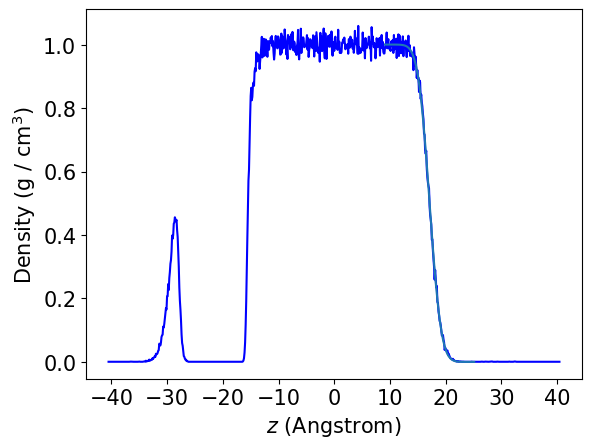

In [65]:
shift = +25
Hposes = []
Oposes = []


water_function = lambda x, xo, scale, height: height*(erf(scale*(x - xo))/2 + 0.5)


for it in range(len(water_oil_pos)):
    pos = water_oil_pos[it]
    typ = water_oil_typ[it]
    box = np.copy(water_oil_box)
    
    fbox = freud.box.Box.from_box(box)

    whO = np.where(typ == 'OH2')[0]
    whH = np.where((typ == 'H1') + (typ == 'H2'))[0]

    Opos = -fbox.wrap(pos[whO] + [0, 0, shift])
    Hpos = -fbox.wrap(pos[whH] + [0, 0, shift])


    Hpos = fbox.wrap(Hpos - [0, 0, np.average(Opos[:,2])])
    Opos = fbox.wrap(Opos - [0, 0, np.average(Opos[:,2])])
    #print(np.average(Opos, axis=0))
    #print(Opos)



    Oposes.append(Opos)
    Hposes.append(Hpos)
        
boxW = box[0]**2
start = 500
tot = np.concatenate(Oposes[start:])
un, co = np.unique(np.round(tot[:,2], 1), return_counts=True)
dens = co/(len(water_oil_pos) - start)/boxW/0.1/(1/18.02 * 6.022 * 10**23 / 10**24)
plt.plot(un, dens, c='Blue')
      

print(len(Oposes))
rwater_var, rwater_cov = curve_fit(water_function, 
                                   un[un > 0], 
                                   dens[un > 0], 
                                   [18, 1, 1],
                                   maxfev = int (2e5))

xx = np.linspace(rwater_var[0] - 8, rwater_var[0]+8)
yy = water_function(xx, *rwater_var)
plt.plot(xx, yy)

plt.ylabel('Density (g / cm$^3$)', fontsize=15)
plt.xlabel('$z$ (Angstrom)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

oilgds = rwater_var[0]

oilOpos = np.copy(Oposes)
oilHpos = np.copy(Hposes) 

print(typ[1])

In [66]:
gridlenx = 36*2
dx = 1/gridlenx
xs = np.linspace(dx/2, 1 - dx/2, gridlenx)
ys = np.copy(xs)

gridlenz = 16*2
dz = 1/gridlenz
zs = np.linspace(dz/2, 1 - dz/2, gridlenz)

grid = []
for x in xs:
    for y in ys:
        for z in zs:
            grid.append([x, y, z])
            
grid = np.array(grid)
print(len(grid))
print(grid)

from skimage import measure


#print(gds)





165888
[[0.00694444 0.00694444 0.015625  ]
 [0.00694444 0.00694444 0.046875  ]
 [0.00694444 0.00694444 0.078125  ]
 ...
 [0.99305556 0.99305556 0.921875  ]
 [0.99305556 0.99305556 0.953125  ]
 [0.99305556 0.99305556 0.984375  ]]


In [67]:
gds = rwater_var[0]
extantz = 16
chi = 2.4
gridxy = 10000*grid[:,0] + grid[:,0]
rmax = chi*3.0
boundaries = []
bdis = []
gdis = []
Hbdis = []
Hgdis = []

for k in range(500, len(oilOpos), 1):
    
    Oposes = np.copy(oilOpos[k])
    Hposes = np.copy(oilHpos[k])
    box = np.copy(water_oil_box)
    
    # Setting up grigd
    mgrid = np.copy(grid)
    mgrid[:,:2] = mgrid[:,:2]*box[:2] - box[:2]/2
    
    mgrid[:,2] = mgrid[:,2] * extantz - extantz/2 + gds
    
    
    # Computing Density on Grid
    tOpos = Oposes[Oposes[:,2] > 0]
    fbox = freud.box.Box.from_box(box)
    aq = freud.locality.AABBQuery(fbox, tOpos)
    nlist = aq.query(mgrid, {'r_max': rmax}).toNeighborList()   
    dgs = np.array([dx*box[0], dx*box[1], dz*extantz])
    dis = np.linalg.norm(fbox.wrap(tOpos[nlist.point_indices] - mgrid[nlist.query_point_indices]), axis=1)
    gauss = 1/(2*np.pi*chi**2)**(3/2)*np.exp(-0.5*(dis/chi)**2)
    gauss = gauss - 1/(2*np.pi*chi**2)**(3/2)*np.exp(-0.5*(rmax/chi)**2)
    
    un, co = np.unique(nlist.query_point_indices, return_counts=True)
    dens = []
    it = 0
    total = np.arange(0, len(mgrid))
    dens = np.zeros(len(grid))
    i = 0
    for u in un:
        et = it + co[i]
        wh = np.arange(it, et)
        dens[u] = np.sum(gauss[wh])
        it = et
        i += 1

    tgrid = np.reshape(dens, [gridlenx, gridlenx, gridlenz])

    # Finding Interface   
    dens = np.array(dens)
    verts, faces, normals, values = measure.marching_cubes(tgrid, 0.016, spacing=(dgs[0], dgs[1], dgs[2]))
    verts[:,2] =  verts[:,2] - extantz/2 + gds + dgs[2]/2
    verts[:,:2] =  verts[:,:2] - box[:2]/2 + dgs[:2]/2

    # Finding how close particles are to Interface
    nneighbors = 1
    tOpos = np.copy(Oposes[Oposes[:,2] > 0])
    gbox = box * np.array([1, 1, 4])
    fbox = freud.box.Box.from_box(gbox)

    aq = freud.locality.AABBQuery(fbox, verts)
    nlist = aq.query(tOpos, {'num_neighbors': nneighbors}).toNeighborList()   
    #print('here1')
    directs = fbox.wrap(verts[nlist.point_indices] - tOpos[nlist.query_point_indices])
    dis = np.linalg.norm(directs, axis=1)
    normed = (directs.T / dis).T
    signs = np.sign(normed[:,2])

    dis = np.sum(directs*normed, axis=1) * signs
    bdis.append(dis)
    gdis.append(tOpos[:,2])
    
    
    tHpos = np.copy(Hposes[Hposes[:,2] > 0])
    gbox = box * np.array([1, 1, 4])
    fbox = freud.box.Box.from_box(gbox)

    aq = freud.locality.AABBQuery(fbox, verts)
    nlist = aq.query(tHpos, {'num_neighbors': nneighbors}).toNeighborList()   
    directs = fbox.wrap(verts[nlist.point_indices] - tHpos[nlist.query_point_indices])
    dis = np.linalg.norm(directs, axis=1)
    normed = (directs.T / dis).T
    signs = np.sign(normed[:,2])

    dis = np.sum(directs*normed, axis=1) * signs
    Hbdis.append(dis)
    Hgdis.append(tHpos[:,2])
    
    
    print(k)
    
oildis = np.array(bdis, dtype='object')


oilHdis = np.array(Hbdis, dtype='object')


#print(airdis)



500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749


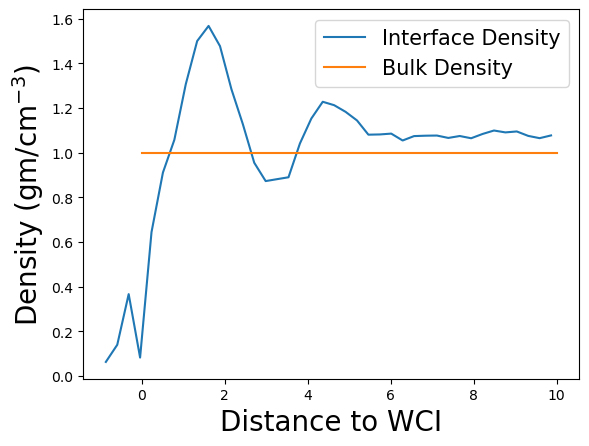

In [78]:
boxW = 36**2 #Area



coco, bins = np.histogram(np.concatenate(oildis), range = (-1, 10.0), bins = 40)
binw = bins[1] - bins[0]
unco = bins[:-1] + binw/2
plt.plot(unco, 
         coco/boxW/binw/len(oildis)/(1/18.02 * 6.022 * 10**23 / 10**24),
         label='Interface Density') # Density Using Oxygens



plt.plot([0, 10], [1, 1], label='Bulk Density')
plt.xlabel("Distance to WCI", size=20)
plt.ylabel("Density (gm/cm$^{-3}$)", size=20)

plt.legend(fontsize=15)


oilnum = np.copy(unco)
oilden = np.copy(coco)

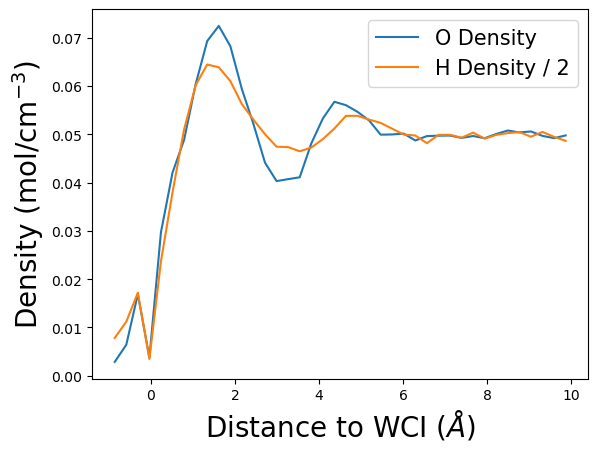

In [79]:
boxW = 36**2 #Area



coco, bins = np.histogram(np.concatenate(oildis), range = (-1, 10.0), bins = 40)
binw = bins[1] - bins[0]
unco = bins[:-1] + binw/2
plt.plot(unco, coco/boxW/binw/len(airdis)/(1 * 6.022 * 10**23 / 10**24), label='O Density') # O positions


coco, bins = np.histogram(np.concatenate(oilHdis), range = (-1, 10.0), bins = 40)
binw = bins[1] - bins[0]
unco = bins[:-1] + binw/2
plt.plot(unco, coco/boxW/binw/len(airdis)/(1 * 6.022 * 10**23 / 10**24)/2, label='H Density / 2') # H positions



plt.xlabel("Distance to WCI ($\AA$)", size=20)
plt.ylabel("Density (mol/cm$^{-3}$)", size=20)

plt.legend(fontsize=15)



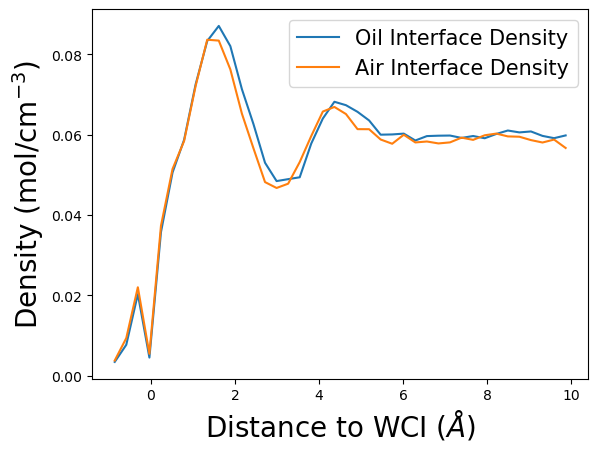

In [76]:
boxW = 36**2 #Area



binw = oilnum[1] - oilnum[0]
plt.plot(oilnum, oilden/boxW/binw/len(oildis)/(1 * 6.022 * 10**23 / 10**24), label='Oil Interface Density')


binw = airnum[1] - airnum[0]
plt.plot(airnum, airden/boxW/binw/len(airdis)/(1 * 6.022 * 10**23 / 10**24), label='Air Interface Density')



plt.xlabel("Distance to WCI ($\AA$)", size=20)
plt.ylabel("Density (mol/cm$^{-3}$)", size=20)

plt.legend(fontsize=15)




In [174]:
# Just oil ops

direct_ops = []

g = [1, 1]

#all_oilnorms = []

cos_thetas = []
    
for it in range(0, len(airOpos), 1):
    #print(it)
    Opos = airOpos[it]
    Hpos = airHpos[it]
    box = np.copy(water_air_box)
    aHpos = np.reshape(np.copy(Hpos), [len(Opos), 2, 3])
    aOpos = np.copy(aHpos)
    aOpos[:,0,:] = np.copy(Opos)
    aOpos[:,1,:] = np.copy(Opos)


    fbox = freud.box.Box.from_box(box)

    directs = np.copy(aOpos)
    directs[:,0,:] = fbox.wrap(aHpos[:,0] - aOpos[:,0])
    directs[:,1,:] = fbox.wrap(aHpos[:,1] - aOpos[:,1])

    directs = np.average(directs, axis=1)
    directs = (directs.T / np.linalg.norm(directs, axis=1)).T



    cos_thetas.append(directs)
    
  
aircos_thetas = np.copy(cos_thetas)








*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


(-30.0, 30.0)

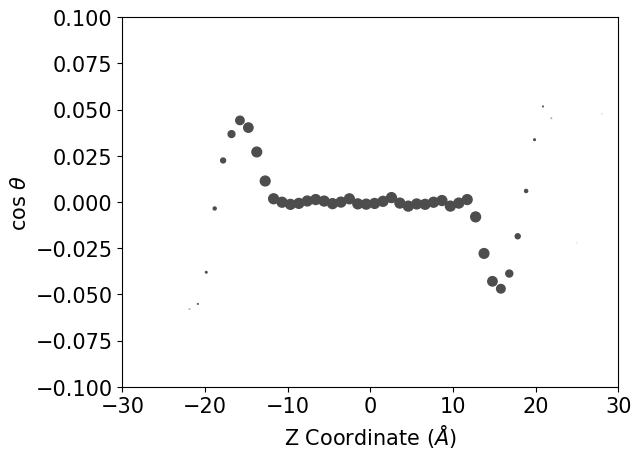

In [175]:
xx = np.linspace(-28, 28, 56)# + fits[i][0]
bounds = xx[1] - xx[0]
ctheta_avgs = []

sizes = []
for x in xx:

    posO = np.concatenate(airOpos[500:])
    rem = np.concatenate(aircos_thetas[500:])


    rem = rem[np.abs(posO[:,2] - x) < bounds, 2]
    avg = np.average(rem)
    ctheta_avgs.append([x, avg])
    sizes.append(len(rem))


airsizes = np.array(sizes)       
ctheta_avgs = np.asarray(ctheta_avgs)
plt.scatter(ctheta_avgs[:,0], ctheta_avgs[:,1], c=[0.3, 0.3, 0.3], s=airsizes/1000)

air_ctheta_avgs = np.copy(ctheta_avgs)
plt.xlabel("Z Coordinate ($\AA$)", size=15)
plt.ylabel("cos $\\theta$", size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.ylim(-0.1, 0.1)
plt.xlim(-30, 30)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


(array([-0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,  0.04,  0.06,
         0.08]),
 [Text(0, -0.1, '−0.10'),
  Text(0, -0.08, '−0.08'),
  Text(0, -0.060000000000000005, '−0.06'),
  Text(0, -0.04000000000000001, '−0.04'),
  Text(0, -0.020000000000000004, '−0.02'),
  Text(0, 0.0, '0.00'),
  Text(0, 0.01999999999999999, '0.02'),
  Text(0, 0.04000000000000001, '0.04'),
  Text(0, 0.06, '0.06'),
  Text(0, 0.07999999999999999, '0.08')])

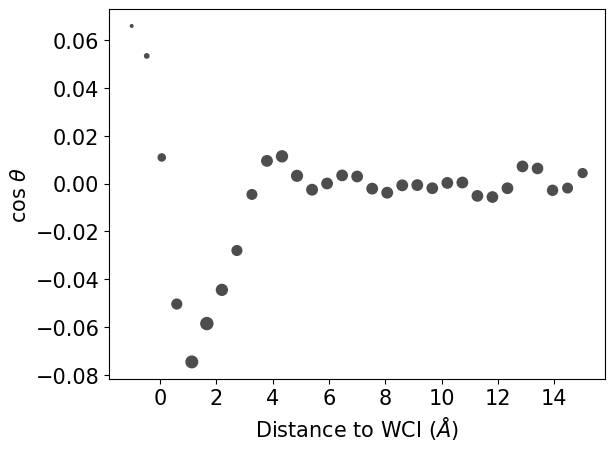

In [189]:
xx = np.linspace(-1, 15, 31)# + fits[i][0]
bounds = xx[1] - xx[0]
ctheta_avgs = []
sizes = []

for x in xx:
    dis = np.concatenate(airdis)
    posO = np.concatenate(airOpos[500:])
    rem = np.concatenate(aircos_thetas[500:])
    rem = rem[posO[:,2] > 0,:]
    rem = rem[np.abs(dis - x) < bounds, 2]
    avg = np.average(rem)
    ctheta_avgs.append([x, avg])
    sizes.append(len(rem))
        
ctheta_avgs = np.asarray(ctheta_avgs)
iairsizes = np.array(sizes)
plt.scatter(ctheta_avgs[:,0], ctheta_avgs[:,1], c=[0.3, 0.3, 0.3], s=iairsizes/500)

iair_ctheta_avgs = np.copy(ctheta_avgs)


plt.xlabel("Distance to WCI ($\AA$)", size=15)

plt.ylabel("cos $\\theta$", size=15)
plt.xticks(size=15)
plt.yticks(size=15)
#plt.ylim(-0.25, 0.25)
#plt.xlim(-2, 11)



In [177]:
# Just oil ops

direct_ops = []

g = [1, 1]

#all_oilnorms = []

cos_thetas = []
    
for it in range(0, len(oilOpos), 1):
    #print(it)
    Opos = oilOpos[it]
    Hpos = oilHpos[it]
    box = np.copy(water_oil_box)
    aHpos = np.reshape(np.copy(Hpos), [len(Opos), 2, 3])
    aOpos = np.copy(aHpos)
    aOpos[:,0,:] = np.copy(Opos)
    aOpos[:,1,:] = np.copy(Opos)


    fbox = freud.box.Box.from_box(box)

    directs = np.copy(aOpos)
    directs[:,0,:] = fbox.wrap(aHpos[:,0] - aOpos[:,0])
    directs[:,1,:] = fbox.wrap(aHpos[:,1] - aOpos[:,1])

    directs = np.average(directs, axis=1)
    directs = (directs.T / np.linalg.norm(directs, axis=1)).T



    cos_thetas.append(directs)
    
  
oilcos_thetas = np.copy(cos_thetas)









*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


(0.0, 30.0)

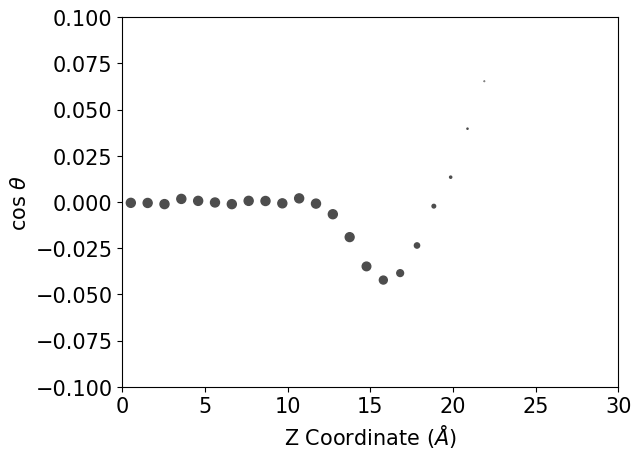

In [178]:
xx = np.linspace(-28, 28, 56)# + fits[i][0]
bounds = xx[1] - xx[0]
ctheta_avgs = []

sizes = []

for x in xx:

    posO = np.concatenate(oilOpos[500:])
    rem = np.concatenate(oilcos_thetas[500:])


    rem = rem[np.abs(posO[:,2] - x) < bounds, 2]
    avg = np.average(rem)
    ctheta_avgs.append([x, avg])
    sizes.append(len(rem))
    
oilsizes = np.array(sizes)       
ctheta_avgs = np.asarray(ctheta_avgs)
plt.scatter(ctheta_avgs[:,0], ctheta_avgs[:,1], c=[0.3, 0.3, 0.3], s=oilsizes/1000)

oil_ctheta_avgs = np.copy(ctheta_avgs)


plt.xlabel("Z Coordinate ($\AA$)", size=15)
plt.ylabel("cos $\\theta$", size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.ylim(-0.1, 0.1)
plt.xlim(0, 30)



*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


(array([-0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,  0.04,  0.06,
         0.08,  0.1 ]),
 [Text(0, -0.1, '−0.10'),
  Text(0, -0.08, '−0.08'),
  Text(0, -0.060000000000000005, '−0.06'),
  Text(0, -0.04000000000000001, '−0.04'),
  Text(0, -0.020000000000000004, '−0.02'),
  Text(0, 0.0, '0.00'),
  Text(0, 0.01999999999999999, '0.02'),
  Text(0, 0.04000000000000001, '0.04'),
  Text(0, 0.06, '0.06'),
  Text(0, 0.07999999999999999, '0.08'),
  Text(0, 0.1, '0.10')])

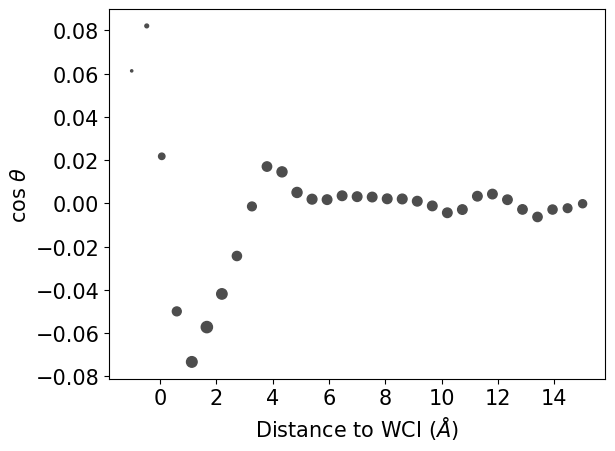

In [188]:
xx = np.linspace(-1, 15, 31)# + fits[i][0]
bounds = xx[1] - xx[0]
ctheta_avgs = []
sizes = []

for x in xx:
    dis = np.concatenate(oildis)
    posO = np.concatenate(oilOpos[500:])
    rem = np.concatenate(oilcos_thetas[500:])
    rem = rem[posO[:,2] > 0,:]
    rem = rem[np.abs(dis - x) < bounds, 2]
    avg = np.average(rem)
    ctheta_avgs.append([x, avg])
    sizes.append(len(rem))
        
ctheta_avgs = np.asarray(ctheta_avgs)
ioilsizes = np.array(sizes)
plt.scatter(ctheta_avgs[:,0], ctheta_avgs[:,1], c=[0.3, 0.3, 0.3], s=ioilsizes/500)
ioil_ctheta_avgs = np.copy(ctheta_avgs)



plt.xlabel("Distance to WCI ($\AA$)", size=15)
plt.ylabel("cos $\\theta$", size=15)
plt.xticks(size=15)
plt.yticks(size=15)
#plt.ylim(-0.25, 0.25)
#plt.xlim(-2, 11)




(0.0, 30.0)

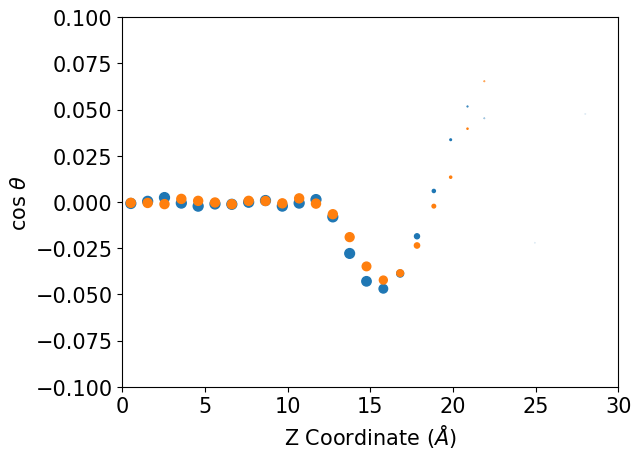

In [184]:
plt.scatter(air_ctheta_avgs[:,0], air_ctheta_avgs[:,1], s=airsizes/1000)
plt.scatter(oil_ctheta_avgs[:,0], oil_ctheta_avgs[:,1], s=oilsizes/1000)


plt.xlabel("Z Coordinate ($\AA$)", size=15)
plt.ylabel("cos $\\theta$", size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.ylim(-0.1, 0.1)
plt.xlim(0, 30)

(-1.0, 11.0)

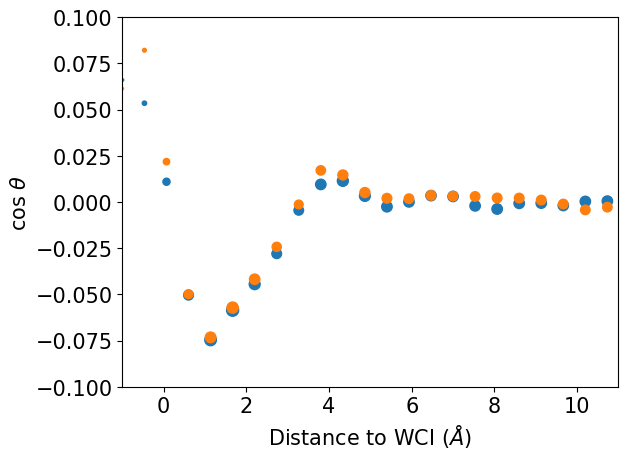

In [190]:
plt.scatter(iair_ctheta_avgs[:,0], iair_ctheta_avgs[:,1], s=iairsizes/500)
plt.scatter(ioil_ctheta_avgs[:,0], ioil_ctheta_avgs[:,1], s=ioilsizes/500)


plt.xlabel("Distance to WCI ($\AA$)", size=15)
plt.ylabel("cos $\\theta$", size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.ylim(-0.1, 0.1)
plt.xlim(-1, 11)